# Models for discriminating SLE patients from healthy controls (Blood Bank Donors)

In [1]:
import os
import pandas as pd
import numpy as np
import feather
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from stability_selection import StabilitySelection, plot_stability_path
from joblib import parallel_backend

from sle.regression import coef_from_sm, coef_plot, make_coef_tbl
from sle.modeling import generate_data, prep_data, eval_model, calc_roc_cv, plot_roc_cv
from sle.penalization import regularization_range, choose_C, regularization_path, plot_regularization_path, coef_plots_regularized
%load_ext autoreload
%autoreload 2

/home/lcreteig/miniconda3/envs/SLE/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


If you want to run the code but don't have access to the data, skip the cell below and run the following instead, to generate some synthetic data:

In [2]:
data_dir = os.path.join('..', 'data', 'processed')
data_all = feather.read_dataframe(os.path.join(data_dir, 'imid.feather'))
X_test_df = feather.read_dataframe(os.path.join(data_dir,'rest.feather'))

In [3]:
X, y = prep_data(data_all, 'SLE', 'BBD', drop_cols = ["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"])
dsDNA = X.dsDNA2.values.reshape(-1,1) # only dsDNA from chip as a vector

In [4]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=40)

### Dummy classifier

Accuracy for dummy classifier:

In [5]:
dummy_clf = DummyClassifier(random_state = 40, strategy = 'most_frequent')
dummy_clf.fit(X, y)
dummy_clf.predict(X),
dummy_clf.score(X,y)

0.5722748815165877

### Logistic regression: Only dsDNA

In [6]:
clf = LogisticRegression(penalty = 'none', max_iter = 10000) # increase iterations for solver to converge

In [7]:
lr_dsDNA = clf.fit(dsDNA, y)

In [8]:
np.mean(cross_val_score(clf, dsDNA, y, cv=cv, scoring = 'roc_auc'))

0.7956906204723647

In [9]:
logreg_dsDNA = sm.Logit(y,sm.add_constant(dsDNA)).fit()

Optimization terminated successfully.
         Current function value: 0.511833
         Iterations 12


In [10]:
np.exp(coef_from_sm(logreg_dsDNA))

,ci_lower,ci_upper,beta
x1,1.015272,1.024399,1.019825


**Test on pre-SLE (vs. rest)**

Threshold for classification: 0.5
              precision    recall  f1-score   support

  rest_large       0.98      0.79      0.87       462
      preSLE       0.10      0.65      0.17        17

    accuracy                           0.78       479
   macro avg       0.54      0.72      0.52       479
weighted avg       0.95      0.78      0.85       479

N.B.: "recall" = sensitivity for the group in this row (e.g. preSLE); specificity for the other group (rest_large)
N.B.: "precision" = PPV for the group in this row (e.g. preSLE); NPV for the other group (rest_large)



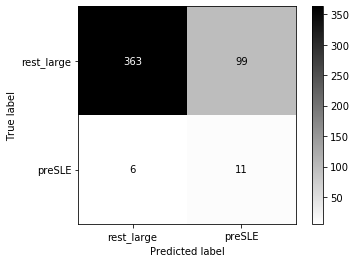

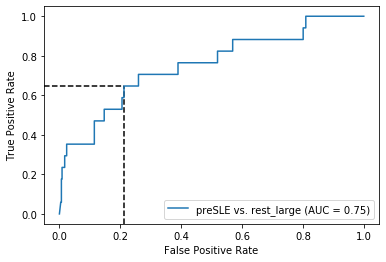

In [11]:
X_test, y_test = prep_data(X_test_df, 'preSLE', 'rest_large', ["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"])
eval_model(lr_dsDNA, X_test.dsDNA2.values.reshape(-1,1), y_test, 'preSLE', 'rest_large')

**Test on LLD (vs. rest)**

Threshold for classification: 0.5
              precision    recall  f1-score   support

  rest_large       0.96      0.79      0.86       462
         LLD       0.12      0.46      0.19        28

    accuracy                           0.77       490
   macro avg       0.54      0.62      0.52       490
weighted avg       0.91      0.77      0.83       490

N.B.: "recall" = sensitivity for the group in this row (e.g. LLD); specificity for the other group (rest_large)
N.B.: "precision" = PPV for the group in this row (e.g. LLD); NPV for the other group (rest_large)



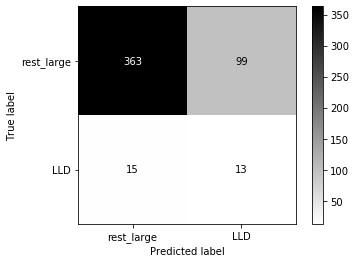

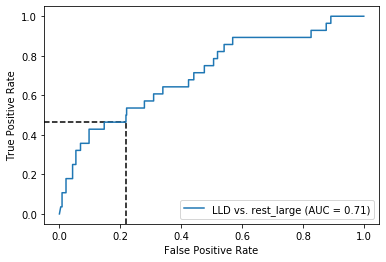

In [12]:
X_test, y_test = prep_data(X_test_df, 'LLD', 'rest_large', ["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"])
eval_model(lr_dsDNA, X_test.dsDNA2.values.reshape(-1,1), y_test, 'LLD', 'rest_large')

**Test on IMID (vs. nonIMID)**

Threshold for classification: 0.5
              precision    recall  f1-score   support

     nonIMID       0.42      0.77      0.55       218
        IMID       0.70      0.34      0.46       346

    accuracy                           0.51       564
   macro avg       0.56      0.55      0.50       564
weighted avg       0.59      0.51      0.49       564

N.B.: "recall" = sensitivity for the group in this row (e.g. IMID); specificity for the other group (nonIMID)
N.B.: "precision" = PPV for the group in this row (e.g. IMID); NPV for the other group (nonIMID)



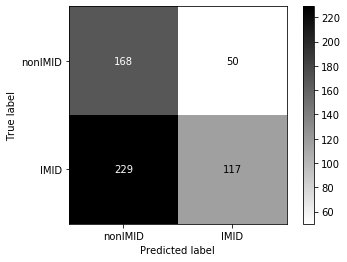

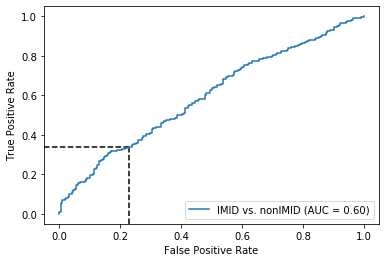

In [13]:
X_test, y_test = prep_data(data_all, 'IMID', 'nonIMID', ["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"])
eval_model(lr_dsDNA, X_test.dsDNA2.values.reshape(-1,1), y_test, 'IMID', 'nonIMID')

### Logistic regression without dsDNA

In [14]:
no_dsDNA = X.drop(columns='dsDNA2')

In [15]:
np.mean(cross_val_score(clf, no_dsDNA, y, cv=cv, scoring = 'roc_auc'))

0.9007552888337073

In [16]:
logreg_no_dsDNA = sm.Logit(y,sm.add_constant(no_dsDNA)).fit()

Optimization terminated successfully.
         Current function value: 0.258118
         Iterations 11


In [17]:
coefs_no_dsDNA = coef_from_sm(logreg_no_dsDNA)

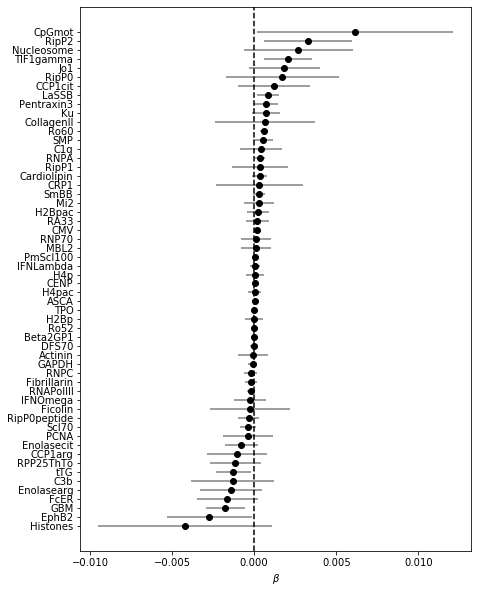

In [18]:
coef_plot(coefs_no_dsDNA, OR=False)

When dropping `dsDNA`, `CpGmot` switches sign, and is now just barely significant (see below)

### Logistic regression with all features

Variance inflation factors

In [19]:
df_cor = X.corr()
vifs = pd.Series(np.linalg.inv(df_cor.values).diagonal(), index=df_cor.index)

In [20]:
vifs[vifs > 2].sort_values(ascending=False)

RipP2           58.668002
RipP1           21.379985
RipP0           19.101134
Enolasearg      11.417301
CCP1arg          7.781867
SmBB             7.486631
SMP              6.739662
EphB2            5.293658
Enolasecit       5.076042
RipP0peptide     4.229254
Ro60             4.180351
Ro52             4.064606
Nucleosome       3.890488
RNPA             3.814536
H2Bp             3.617355
H2Bpac           3.566022
H4p              3.216518
dsDNA2           3.054496
RNP70            3.052853
RNPC             2.869649
CpGmot           2.847054
H4pac            2.793631
Histones         2.727817
CCP1cit          2.692775
dtype: float64

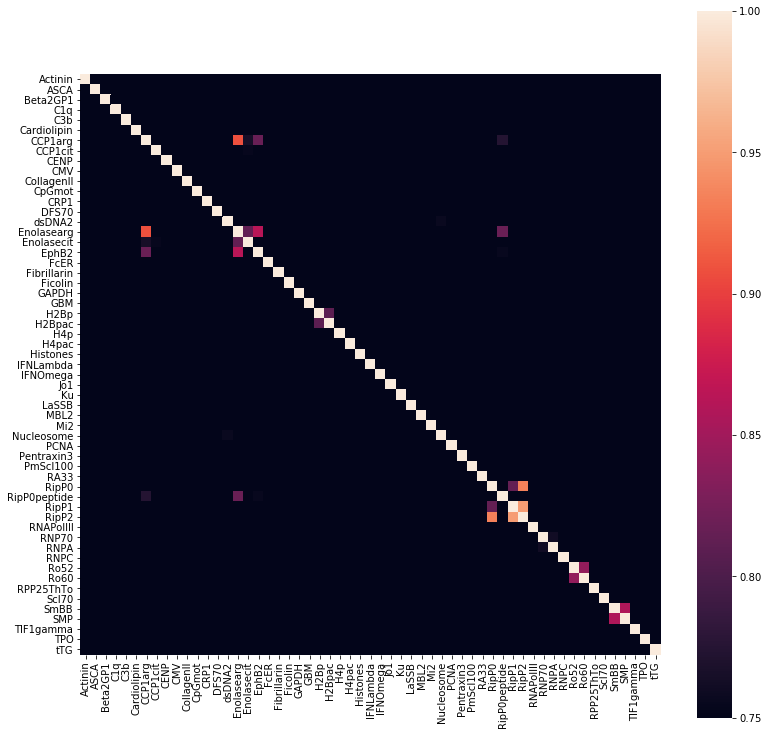

In [21]:
plt.figure(figsize=(13,13))
sns.heatmap(df_cor, vmin=0.75, square = True)

Work down the list of VIFs. Whenever a correlation exceeds threshold, discard feature with highest VIF:

In [22]:
# Set without correlations above .9
X_nocor90 = X.drop(columns = [
    'RipP2', # with RipP1 and RipP0
    'Enolasearg' # with CCP1arg
])

In [23]:
# Set without correlations above .85
X_nocor85 = X.drop(columns = [
    'RipP2', # with RipP1 and RipP0
    'Enolasearg', # with CCP1arg, EphB2
    'SmBB' # with SMP
])

In [24]:
# Set without correlations above .8
X_nocor80 = X.drop(columns = [
    'RipP2', 'RipP1', # with RipP0
    'Enolasearg', # with CCP1arg, EphB2, Enolasecit, RipP0peptide
    'CCP1arg', # with EphB2
    'SmBB', # with SMP
    'Ro60', # with Ro52
    'H2Bp' # with H2Bpac
])

#### Without scaling:

In [25]:
np.mean(cross_val_score(clf, X, y, cv=cv, scoring = 'roc_auc'))

0.9111973993393901

Repeat with `statsmodels`, to get coefs / odds ratios and CIs:

In [26]:
logreg = sm.Logit(y,sm.add_constant(X)).fit()

Optimization terminated successfully.
         Current function value: 0.234249
         Iterations 13


In [27]:
logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Class   No. Observations:                  844
Model:                          Logit   Df Residuals:                      786
Method:                           MLE   Df Model:                           57
Date:                Mon, 09 May 2022   Pseudo R-squ.:                  0.6569
Time:                        13:24:41   Log-Likelihood:                -197.71
converged:                       True   LL-Null:                       -576.17
Covariance Type:            nonrobust   LLR p-value:                6.396e-123
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.5171      0.462     -3.287      0.001      -2.422      -0.612
Actinin       6.162e-05      0.001      0.123      0.902      -0.001       0.001
ASCA          1.062e-05   5.84e-05      0.182      0.856      -0.000       0.000
Beta2GP1      2.825e-05   5.28e-05      0.535      0.593   -7.53e-05       0.000
C1q             -0.0003      0.001     -0.294      0.769      -0.002       0.001
C3b             -0.0019      0.001     -1.315      0.189      -0.005       0.001
Cardiolipin      0.0002      0.000      0.753      0.452      -0.000       0.001
CCP1arg         -0.0011      0.001     -1.256      0.209      -0.003       0.001
CCP1cit          0.0017      0.001      1.329      0.184      -0.001       0.004
CENP          3.866e-05   5.37e-05      0.720      0.472   -6.67e-05       0.000
CMV              0.0002   5.86e-05      2.743      0.006    4.59e-05       0.000
CollagenII      -0.0024      0.001     -1.674      0.094      -0.005       0.000
CpGmot          -0.0046      0.003     -1.383      0.167      -0.011       0.002
CRP1             0.0011      0.002      0.635      0.526      -0.002       0.004
DFS70        -1.886e-05      0.000     -0.168      0.867      -0.000       0.000
dsDNA2           0.0126      0.003      4.164      0.000       0.007       0.019
Enolasearg      -0.0003      0.001     -0.356      0.722      -0.002       0.002
Enolasecit      -0.0008      0.001     -1.437      0.151      -0.002       0.000
EphB2           -0.0026      0.001     -1.900      0.057      -0.005    8.39e-05
FcER            -0.0006      0.001     -0.626      0.532      -0.003       0.001
Fibrillarin     -0.0002      0.000     -0.943      0.346      -0.001       0.000
Ficolin         -0.0005      0.002     -0.301      0.764      -0.003       0.003
GAPDH        -8.543e-05      0.000     -0.629      0.529      -0.000       0.000
GBM             -0.0018      0.001     -2.750      0.006      -0.003      -0.001
H2Bp            -0.0001      0.000     -0.292      0.770      -0.001       0.001
H2Bpac           0.0004      0.000      0.761      0.447      -0.001       0.001
H4p          -2.944e-05      0.000     -0.099      0.921      -0.001       0.001
H4pac         4.735e-05      0.000      0.230      0.818      -0.000       0.000
Histones        -0.0036      0.003     -1.304      0.192      -0.009       0.002
IFNLambda        0.0001      0.000      0.848      0.397      -0.000       0.000
IFNOmega        -0.0001      0.000     -0.271      0.787      -0.001       0.001
Jo1              0.0025      0.001      2.114      0.034       0.000       0.005
Ku               0.0010      0.000      1.984      0.047    1.19e-05       0.002
LaSSB            0.0009      0.000      2.652      0.008       0.000       0.001
MBL2         -3.243e-05      0.001     -0.061      0.951      -0.001       0.001
Mi2              0.0004      0.000      0.811      0.417      -0.001       0.001
Nucleosome      -0.0002      0.001     -0.197      0.844      -0.002       0.001
P

Sorted coefficients with CIs:

In [28]:
coefs = coef_from_sm(logreg)

Plot Odds ratios:

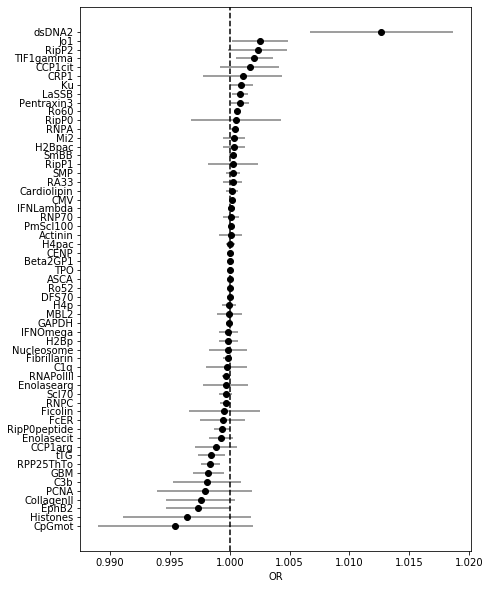

In [29]:
coef_plot(np.exp(coefs), OR=True)

#### With standardization:

In [30]:
pipe_sc = Pipeline([
        ('scale', RobustScaler()), # try RobustScaler because the data is highly skewed and have outliers
        ('clf', clf)])

In [31]:
np.mean(cross_val_score(pipe_sc, X, y, cv=cv, scoring = 'roc_auc'))

0.9117359345823722

In [32]:
scale=RobustScaler()
X_sc = pd.DataFrame(scale.fit_transform(X), index=X.index, columns=X.columns)

In [33]:
logreg_sc = sm.Logit(y,sm.add_constant(X_sc)).fit()

Optimization terminated successfully.
         Current function value: 0.234249
         Iterations 13


In [34]:
coefs_sc = coef_from_sm(logreg_sc)

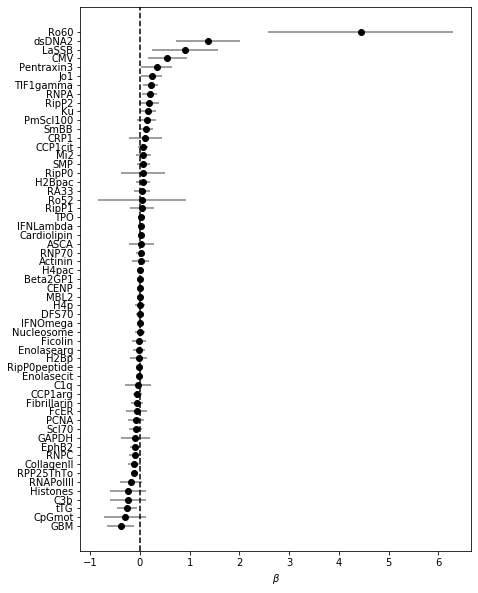

In [35]:
coef_plot(coefs_sc, OR=False) # plotting ORs here is not feasible as Ro60 is so large

This makes `Ro60` the highest-weighted feature, cf. XGBoost

#### With standardization + Box-Cox:

In [36]:
Xp1 = X + 1 # Some values are between -1 and 0. Because negative fluorescence isn't possible, and Box-Cox requires strictly positive values, add ofset

In [37]:
trf = PowerTransformer(method='box-cox')
pipe_trf = Pipeline([
        ('transform', trf),
        ('clf', clf)])

In [38]:
np.mean(cross_val_score(pipe_trf, Xp1, y, cv=cv, scoring = 'roc_auc'))

0.9692078370914341

In [39]:
X_trf = pd.DataFrame(trf.fit_transform(Xp1), index=X.index, columns=X.columns)

In [40]:
logreg_trf = sm.Logit(y,sm.add_constant(X_trf)).fit()

Optimization terminated successfully.
         Current function value: 0.089226
         Iterations 11


In [41]:
logreg_trf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Class   No. Observations:                  844
Model:                          Logit   Df Residuals:                      786
Method:                           MLE   Df Model:                           57
Date:                Mon, 09 May 2022   Pseudo R-squ.:                  0.8693
Time:                        13:25:04   Log-Likelihood:                -75.307
converged:                       True   LL-Null:                       -576.17
Covariance Type:            nonrobust   LLR p-value:                9.702e-173
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.5543      0.743      6.130      0.000       3.098       6.011
Actinin         -0.8145      0.400     -2.038      0.042      -1.598      -0.031
ASCA            -0.2700      0.301     -0.896      0.370      -0.861       0.321
Beta2GP1        -0.4904      0.309     -1.589      0.112      -1.095       0.114
C1q             -0.4621      0.425     -1.088      0.277      -1.294       0.370
C3b             -0.9447      0.456     -2.072      0.038      -1.838      -0.051
Cardiolipin     -0.2555      0.286     -0.893      0.372      -0.816       0.305
CCP1arg         -1.0606      0.446     -2.376      0.018      -1.936      -0.186
CCP1cit          0.1408      0.515      0.273      0.785      -0.869       1.150
CENP            -0.1280      0.269     -0.476      0.634      -0.655       0.399
CMV             -0.2295      0.295     -0.779      0.436      -0.807       0.348
CollagenII       0.7417      0.326      2.275      0.023       0.103       1.381
CpGmot           0.0019      0.711      0.003      0.998      -1.392       1.395
CRP1             0.3503      0.441      0.795      0.427      -0.513       1.214
DFS70           -0.1203      0.341     -0.353      0.724      -0.788       0.548
dsDNA2           5.3738      1.051      5.115      0.000       3.315       7.433
Enolasearg       0.5916      0.370      1.598      0.110      -0.134       1.317
Enolasecit      -0.5567      0.569     -0.978      0.328      -1.672       0.558
EphB2           -0.0102      0.391     -0.026      0.979      -0.777       0.756
FcER             0.1500      0.294      0.510      0.610      -0.427       0.727
Fibrillarin     -0.2806      0.306     -0.917      0.359      -0.880       0.319
Ficolin          0.8266      0.368      2.245      0.025       0.105       1.548
GAPDH           -0.3229      0.321     -1.007      0.314      -0.951       0.306
GBM             -1.2108      0.378     -3.206      0.001      -1.951      -0.470
H2Bp             0.5583      0.548      1.018      0.309      -0.516       1.633
H2Bpac           0.0365      0.509      0.072      0.943      -0.962       1.035
H4p             -1.0386      0.481     -2.161      0.031      -1.981      -0.097
H4pac            0.1825      0.369      0.495      0.620      -0.540       0.905
Histones        -2.0035      0.514     -3.896      0.000      -3.011      -0.996
IFNLambda        0.5550      0.336      1.650      0.099      -0.104       1.214
IFNOmega         0.2533      0.269      0.941      0.347      -0.274       0.781
Jo1             -0.0686      0.352     -0.195      0.845      -0.758       0.621
Ku              -0.3340      0.353     -0.945      0.344      -1.027       0.359
LaSSB            2.3330      0.495      4.713      0.000       1.363       3.303
MBL2             0.0647      0.318      0.203      0.839      -0.559       0.689
Mi2              0.2443      0.320      0.762      0.446      -0.384       0.872
Nucleosome       0.0982      0.619      0.159      0.874      -1.116       1.312
P

In [42]:
coefs_trf = coef_from_sm(logreg_trf)

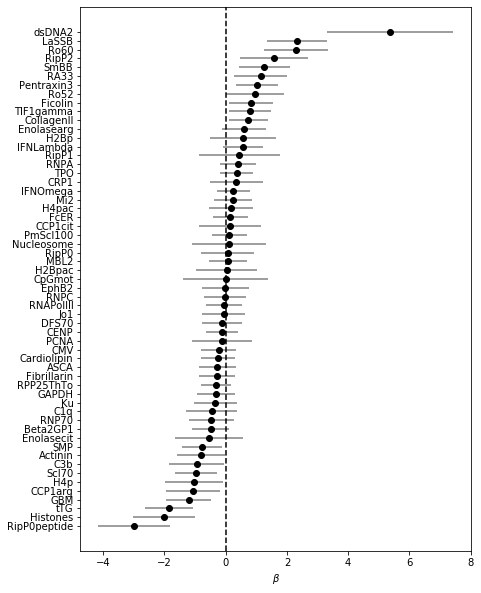

In [43]:
coef_plot(coefs_trf, OR=False) # plotting ORs here is not feasible as dsDNA is so large

Note that once normalized in this way, coefficient for `CpGmot` becomes very small!

### Penalized logistic regression

In [44]:
trf = PowerTransformer(method='box-cox')

#### Ridge

Choose range for regularization:

In [45]:
# for ridge, pick alpha close to zero (if zero, max lambda is infinite. pick alpha=1e-3 to get same as glmnet) 
# and widen the range between lambda max and min (epsilon)
lambda_min, lambda_max = regularization_range(Xp1,y,trf,alpha=1e-2, epsilon=1e-6)

Choose a final value for the regularization parameter with the 1 SE rule (as just choosing the best lambda tends to under-regularize, https://stats.stackexchange.com/questions/138569) 

In [46]:
clf_ridge = LogisticRegression(penalty='l2', max_iter = 10000)
K = 100
Cs_ridge = np.logspace(np.log10(1/lambda_min), np.log10(1/lambda_max), K) # C is inverse of lambda
pipe = Pipeline([
        ('trf', trf),
        ('clf', clf_ridge)
])
params = [{
    "clf__C": Cs_ridge
}]

search_ridge = GridSearchCV(pipe, params, cv = cv, scoring = 'roc_auc', refit=choose_C)

In [47]:
%%time
search_ridge.fit(Xp1,y)

CPU times: user 8min 54s, sys: 13min 30s, total: 22min 24s
Wall time: 6min 10s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=40),
             estimator=Pipeline(steps=[('trf',
                                        PowerTransformer(method='box-cox')),
                                       ('clf',
                                        LogisticRegression(max_iter=10000))]),
             param_grid=[{'clf__C': array([3.42342671e+01, 2.97752197e+01, 2.58969676e+01, 2.25238618e+01,
       1.95901063e+01, 1.70384754e+01, 1.48191970e+01, 1.28889818e+01,
       1.12101...
       4.85261892e-04, 4.22056046e-04, 3.67082825e-04, 3.19269921e-04,
       2.77684695e-04, 2.41515987e-04, 2.10058289e-04, 1.82697987e-04,
       1.58901392e-04, 1.38204327e-04, 1.20203076e-04, 1.04546505e-04,
       9.09292187e-05, 7.90855973e-05, 6.87846194e-05, 5.98253541e-05,
       5.20330420e-05, 4.52556864e-05, 3.93610881e-05, 3.42342671e-05])}],
             refit=<function choose_C at 0x7fecee7479e0>, scoring='roc_auc')

Best model:

In [48]:
search_ridge.cv_results_['mean_test_score'].max()

0.9784842809330654

Score with lambda selected through 1 SE rule:

In [49]:
search_ridge.cv_results_['mean_test_score'][search_ridge.best_index_]

0.9766731818847515

Plot coefficients for different levels of regularization:

In [50]:
coefs_ridge, nnz_coefs_ridge = regularization_path(Cs_ridge, clf_ridge, X_trf, y)

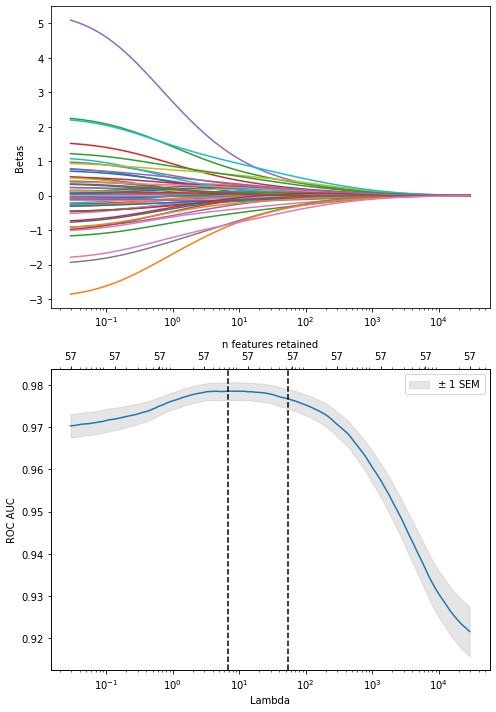

In [51]:
ax1, ax2, ax22 = plot_regularization_path(1/Cs_ridge, coefs_ridge, nnz_coefs_ridge, search_ridge.cv_results_)

With nested cross-validation:

In [52]:
#np.mean(cross_val_score(search_ridge, Xp1, y, cv=cv, scoring = 'roc_auc'))

#### LASSO

In [53]:
lambda_min, lambda_max = regularization_range(Xp1,y,trf)

In [54]:
clf_lasso = LogisticRegression(penalty='l1', max_iter = 10000, solver = 'liblinear')
K = 100
Cs_lasso = np.logspace(np.log10(1/lambda_min),np.log10(1/lambda_max), K)
#Cs_lasso = l1_min_c(trf.fit_transform(Xp1), y, loss='log') * np.logspace(0, 3, 100)
pipe = Pipeline([
        ('trf', trf),
        ('clf', clf_lasso)
])
params = [{
    "clf__C": Cs_lasso
}]

search_lasso = GridSearchCV(pipe, params, cv = cv, scoring = 'roc_auc', refit=choose_C)

In [55]:
%%time
search_lasso.fit(Xp1,y)

CPU times: user 8min 31s, sys: 14min 55s, total: 23min 27s
Wall time: 4min 52s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=40),
             estimator=Pipeline(steps=[('trf',
                                        PowerTransformer(method='box-cox')),
                                       ('clf',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             param_grid=[{'clf__C': array([3.42342671, 3.19269921, 2.97752197, 2.77684695, 2.58969676,
       2.41515987, 2.25238618, 2.10058289, 1.95901...
       0.02589697, 0.0241516 , 0.02252386, 0.02100583, 0.01959011,
       0.0182698 , 0.01703848, 0.01589014, 0.0148192 , 0.01382043,
       0.01288898, 0.01202031, 0.01121018, 0.01045465, 0.00975004,
       0.00909292, 0.00848009, 0.00790856, 0.00737555, 0.00687846,
       0.00641488, 0.00598254, 0.00557933, 0.0052033 , 0.00485262,
       0.00452557, 0.00

Best model:

In [56]:
search_lasso.cv_results_['mean_test_score'].max()

0.9829858422316895

Score with lambda selected through 1 SE rule:

In [57]:
search_lasso.cv_results_['mean_test_score'][search_lasso.best_index_]

0.9813334351642632

In [58]:
coefs_lasso, nnz_coefs_lasso = regularization_path(Cs_lasso, clf_lasso, X_trf, y)

/home/lcreteig/miniconda3/envs/SLE/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(0.9, 1)

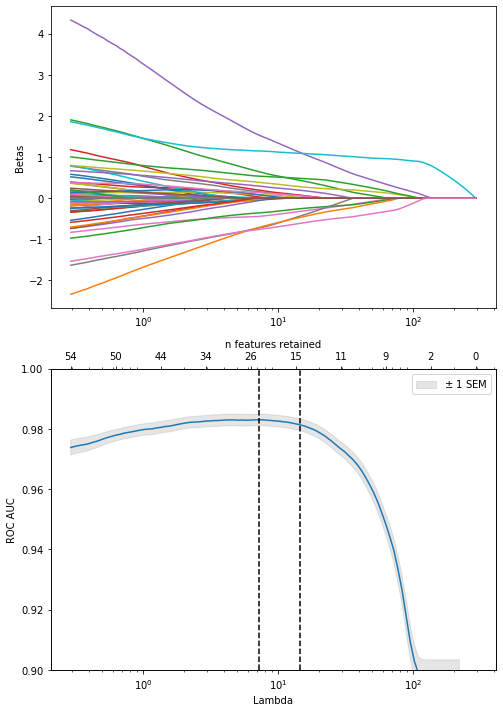

In [59]:
ax1, ax2, ax22 = plot_regularization_path(1/Cs_lasso, coefs_lasso, nnz_coefs_lasso, search_lasso.cv_results_)
ax22.set_ylim([.9, 1])

Plot the coefficients for models with different levels of regularization (= number of features retained). Start with the model with the best CV ROC AUC, and work our way down to include less and less features:

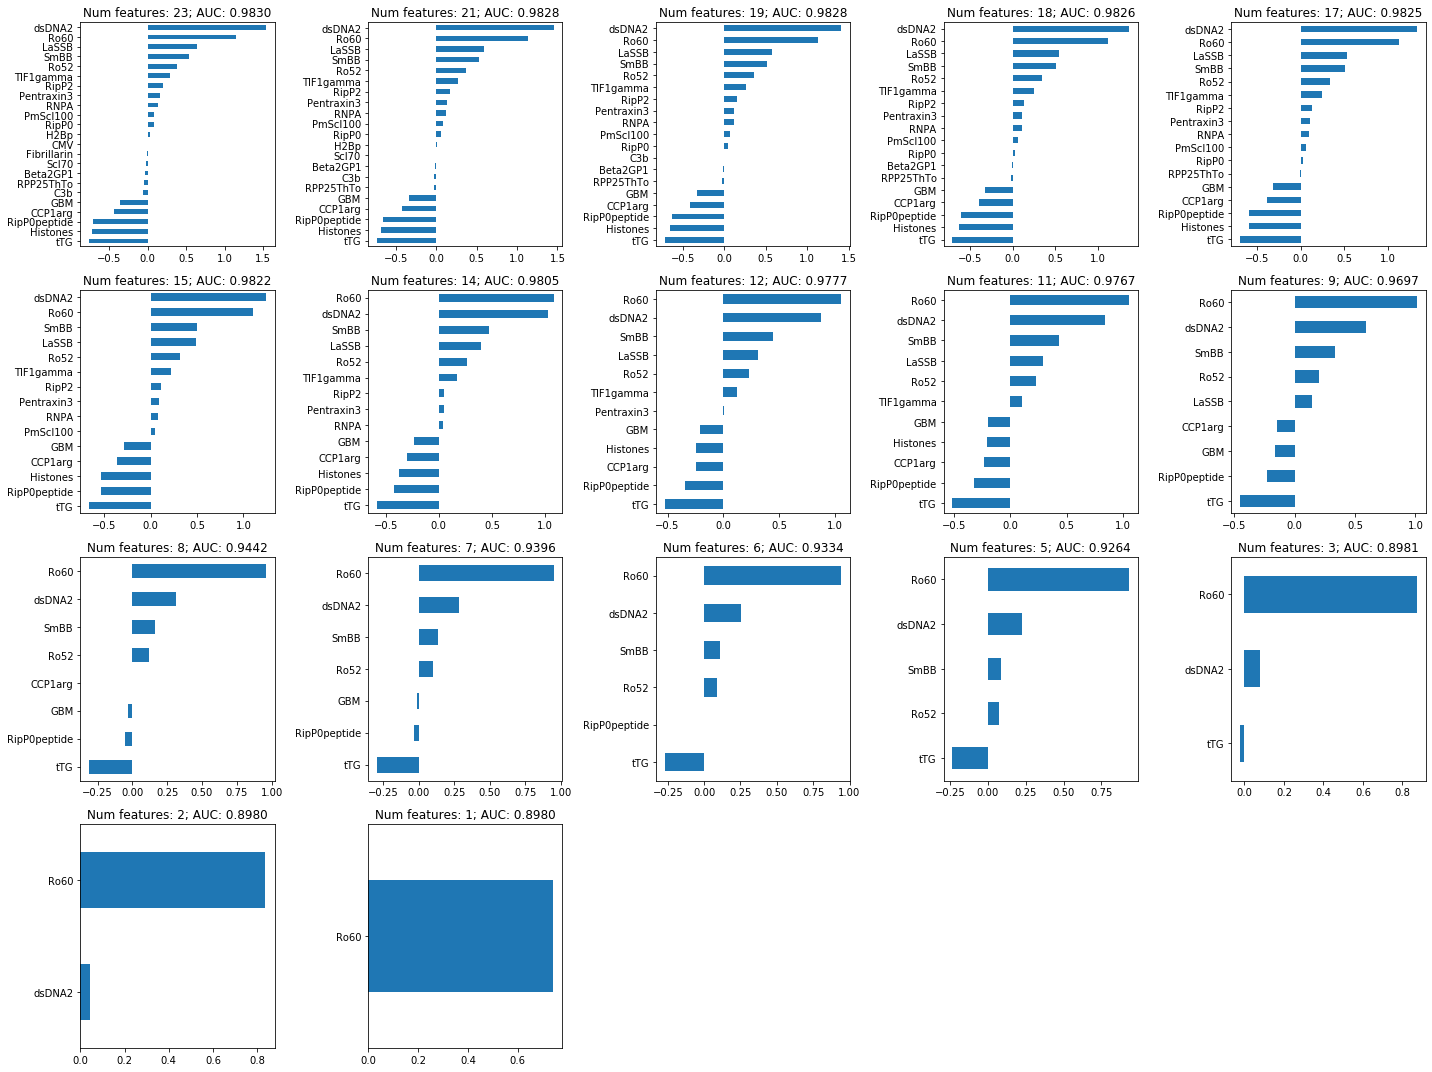

In [60]:
coef_plots_regularized(coefs_lasso, nnz_coefs_lasso, search_lasso.cv_results_["mean_test_score"], X.columns)

Although a lambda that leaves 23 features seems best, AUC only really starts to drop at around 15 features.

Non-zero coefficients of the model selected with the 1SE rule:

In [61]:
coefs_final = (pd.Series(search_lasso.best_estimator_.named_steps.clf.coef_.squeeze(), index = X.columns)
 .where(lambda x : x!=0).
 dropna()
 .sort_values())
coefs_final

tTG            -0.612562
RipP0peptide   -0.468708
Histones       -0.436773
CCP1arg        -0.321419
GBM            -0.256901
PmScl100        0.016689
RNPA            0.060150
Pentraxin3      0.063666
RipP2           0.073611
TIF1gamma       0.193812
Ro52            0.278128
LaSSB           0.433654
SmBB            0.482324
Ro60            1.093204
dsDNA2          1.113356
dtype: float64

Table with all coefficients:

In [62]:
make_coef_tbl(logreg_trf, search_lasso.best_estimator_.named_steps.clf, X.columns)

,coef_regularized,coef,std err,95%CI
const,0.760,4.554,0.743,"3.098, 6.011"
Actinin,0.000,-0.814,0.400,"-1.598, -0.031"
ASCA,0.000,-0.270,0.301,"-0.861, 0.321"
Beta2GP1,0.000,-0.490,0.309,"-1.095, 0.114"
C1q,0.000,-0.462,0.425,"-1.294, 0.37"
C3b,0.000,-0.945,0.456,"-1.838, -0.051"
Cardiolipin,0.000,-0.256,0.286,"-0.816, 0.305"
CCP1arg,-0.321,-1.061,0.446,"-1.936, -0.186"
CCP1cit,0.000,0.141,0.515,"-0.869, 1.15"
CENP,0.000,-0.128,0.269,"-0.655, 0.399"


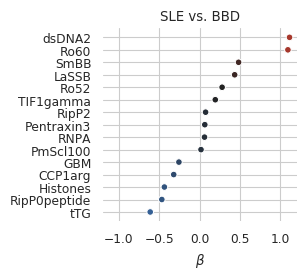

In [63]:
sns.reset_defaults()
pal = sns.diverging_palette(250, 15, s=75, l=40, center="dark", as_cmap=True)
with sns.plotting_context("paper"):
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(figsize=(2.5, 2.5))
        g = sns.scatterplot(y=coefs_final.index, x=coefs_final.values, 
                            hue=coefs_final.values, palette=pal, legend=False)
        ax.set(title='SLE vs. BBD',
               xticks=np.linspace(-1.0,1.0,5), xlim=[-1.2,1.2], xlabel=r'$\beta$')
        sns.despine(fig=fig,ax=ax, left=True, bottom=True)
        #fig.savefig('coefs_SLE_BBD.png', bbox_inches='tight', dpi=300, transparent=True)
        #fig.savefig('coefs_SLE_BBD.pdf', bbox_inches='tight', transparent=True)

Plot cross-validated ROC:

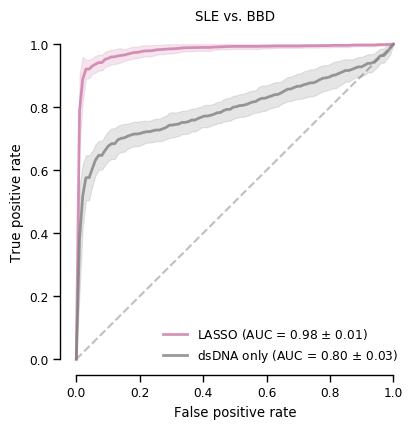

In [64]:
sns.reset_defaults()
with sns.plotting_context("paper"):
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    tprs, aucs = calc_roc_cv(search_lasso.best_estimator_,cv,Xp1,y)
    fig, ax = plot_roc_cv(tprs, aucs, fig, ax, fig_title='SLE vs. BBD', line_color='#CC79A7', legend_label='LASSO')
    tprs, aucs = calc_roc_cv(lr_dsDNA,cv,dsDNA,y)
    fig, ax = plot_roc_cv(tprs, aucs, fig, ax, reuse=True, line_color='gray', legend_label='dsDNA only')
    sns.despine(fig=fig,ax=ax, trim=True)
    plt.legend(frameon=False)
    plt.show()
    #fig.savefig('roc_SLE_BBD.png', bbox_inches='tight', dpi=300, transparent=True)
    #fig.savefig('roc_SLE_BBD.pdf', bbox_inches='tight', dpi=300, transparent=True)

##### Stability selection

If we pick a certain lambda value, the features that get included might vary with a different dataset. We can estimate that variability by taking bootstrap samples of the dataset. Then we can select the features that are included most often

In [65]:
%%time
selector = StabilitySelection(base_estimator=pipe, lambda_name='clf__C',
                                  lambda_grid=Cs_lasso[np.argmax(search_lasso.cv_results_["mean_test_score"]):], #range from highest scoring lambda to lambda_max
                                  random_state=40) 
selector.fit(Xp1, y)

CPU times: user 7min 37s, sys: 0 ns, total: 7min 37s
Wall time: 7min 37s


StabilitySelection(base_estimator=Pipeline(steps=[('trf',
                                                   PowerTransformer(method='box-cox')),
                                                  ('clf',
                                                   LogisticRegression(max_iter=10000,
                                                                      penalty='l1',
                                                                      solver='liblinear'))]),
                   lambda_grid=array([0.13820433, 0.12888982, 0.12020308, 0.11210179, 0.10454651,
       0.09750042, 0.09092922, 0.08480089, 0.0790856 , 0.07375549,
       0.06878462, 0.06414877, 0.05982535, 0.05579333, 0.052033...
       0.0241516 , 0.02252386, 0.02100583, 0.01959011, 0.0182698 ,
       0.01703848, 0.01589014, 0.0148192 , 0.01382043, 0.01288898,
       0.01202031, 0.01121018, 0.01045465, 0.00975004, 0.00909292,
       0.00848009, 0.00790856, 0.00737555, 0.00687846, 0.00641488,
       0.00598254, 0.00557933, 0

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fecdb511e10>)

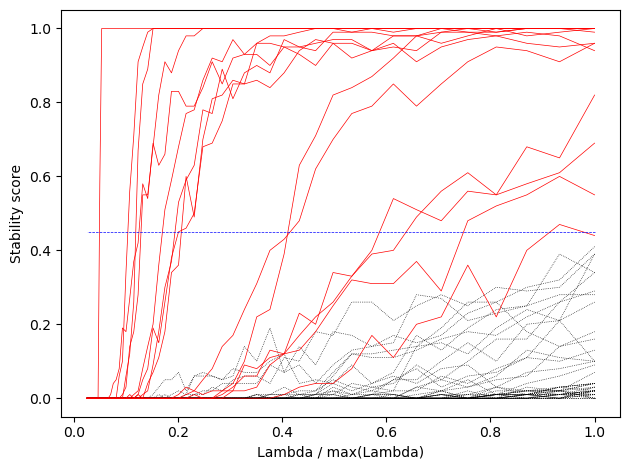

In [66]:
thresh = .45
plot_stability_path(selector, threshold_highlight=thresh)

In [67]:
selector.set_params(threshold=thresh)
selected_variables = selector.get_support(indices=True)
selected_scores = selector.stability_scores_.max(axis=1)

pd.DataFrame({'Variable': Xp1.columns[selected_variables], 
              'Stability score': selected_scores[selected_variables]}).sort_values(by='Stability score', ascending=False)

,Variable,Stability score
0,CCP1arg,1.00
1,dsDNA2,1.00
3,Histones,1.00
4,LaSSB,1.00
7,RipP0peptide,1.00
11,Ro60,1.00
12,SmBB,1.00
14,tTG,1.00
2,GBM,0.99
10,Ro52,0.98


This overlaps completely with the LASSO model fit on the whole dataset

**Test on pre-SLE (vs. rest)**

Threshold for classification: 0.5
              precision    recall  f1-score   support

  rest_large       0.96      0.23      0.36       462
      preSLE       0.04      0.76      0.07        17

    accuracy                           0.24       479
   macro avg       0.50      0.49      0.22       479
weighted avg       0.93      0.24      0.35       479

N.B.: "recall" = sensitivity for the group in this row (e.g. preSLE); specificity for the other group (rest_large)
N.B.: "precision" = PPV for the group in this row (e.g. preSLE); NPV for the other group (rest_large)



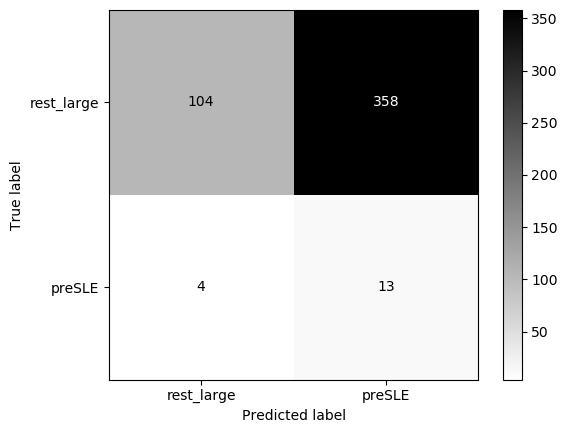

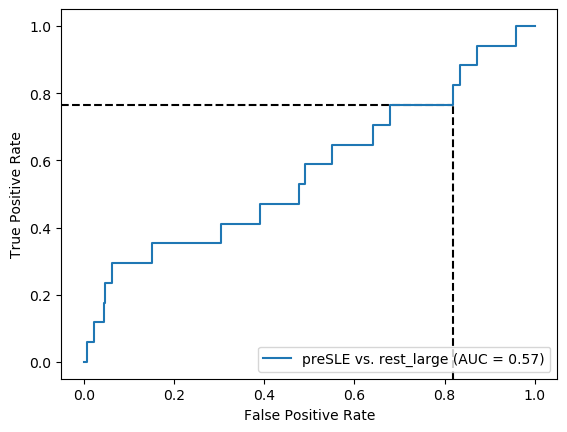

In [68]:
X_test, y_test = prep_data(X_test_df, 'preSLE', 'rest_large', ["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"])
eval_model(search_lasso, X_test+1, y_test, 'preSLE', 'rest_large')

Sensitivity is a bit better than when only using dsDNA, but everything else is worse

**Test on LLD (vs. rest)**

Threshold for classification: 0.5
              precision    recall  f1-score   support

  rest_large       0.95      0.23      0.36       462
         LLD       0.06      0.82      0.11        28

    accuracy                           0.26       490
   macro avg       0.51      0.52      0.24       490
weighted avg       0.90      0.26      0.35       490

N.B.: "recall" = sensitivity for the group in this row (e.g. LLD); specificity for the other group (rest_large)
N.B.: "precision" = PPV for the group in this row (e.g. LLD); NPV for the other group (rest_large)



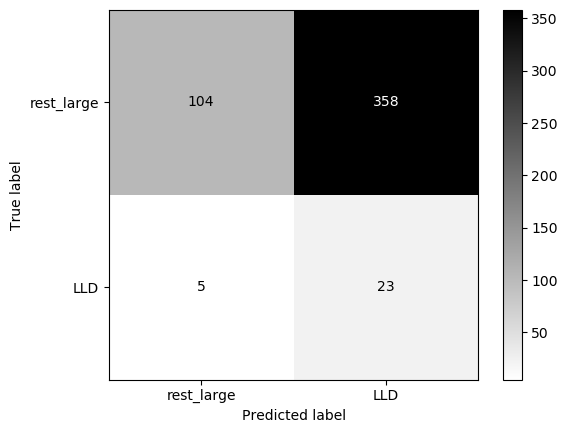

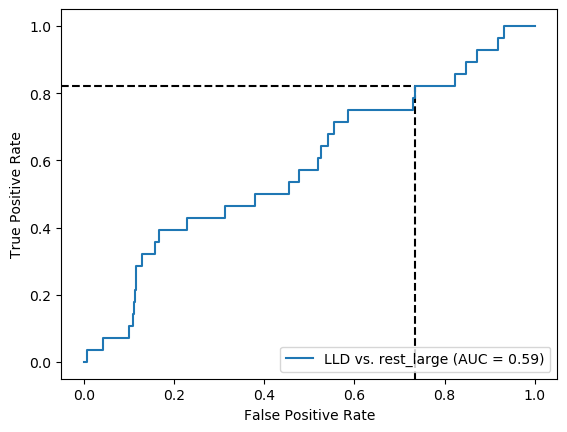

In [69]:
X_test, y_test = prep_data(X_test_df, 'LLD', 'rest_large', ["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"])
eval_model(search_lasso, X_test+1, y_test, 'LLD', 'rest_large')

Similar to preSLE. Seems that when trained on blood bank controls, model classifies everyone as a patient

**Test on IMID (vs. nonIMID)**

Threshold for classification: 0.5
              precision    recall  f1-score   support

     nonIMID       0.49      0.21      0.29       218
        IMID       0.63      0.86      0.73       346

    accuracy                           0.61       564
   macro avg       0.56      0.54      0.51       564
weighted avg       0.58      0.61      0.56       564

N.B.: "recall" = sensitivity for the group in this row (e.g. IMID); specificity for the other group (nonIMID)
N.B.: "precision" = PPV for the group in this row (e.g. IMID); NPV for the other group (nonIMID)



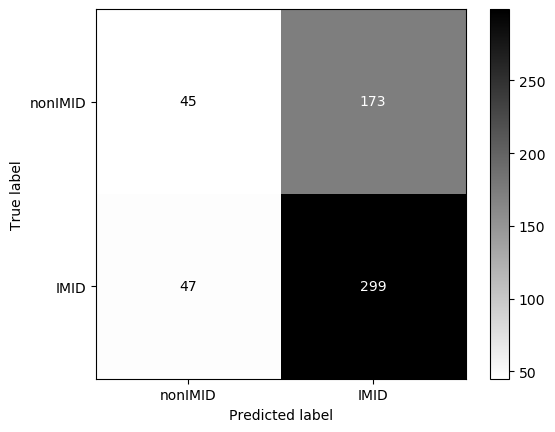

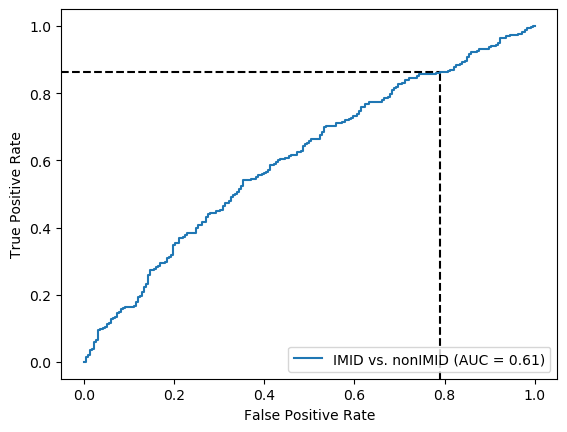

In [70]:
X_test, y_test = prep_data(data_all, 'IMID', 'nonIMID', ["Arthritis","Pleurisy","Pericarditis","Nefritis"] + ["dsDNA1"])
eval_model(search_lasso, X_test+1, y_test, 'IMID', 'nonIMID')

#### Elastic net

In [71]:
clf_enet = LogisticRegression(penalty='elasticnet', max_iter = 10000, solver = 'saga', n_jobs=-1)
Cs = 1/np.logspace(-3,3,20) # C is inverse of lambda
l1l2 = np.linspace(0,1,10) # 0 = l2 only; 1 = l1 only
pipe = Pipeline([
        ('trf', trf),
        ('clf', clf_enet)
])
params = [{
    "clf__C": Cs,
    "clf__l1_ratio": l1l2
}]

search_enet = GridSearchCV(pipe, params, cv = cv, scoring = 'roc_auc', n_jobs=-1)

In [72]:
%%time
with parallel_backend('threading'):
    search_enet.fit(Xp1,y)

CPU times: user 1h 40min 45s, sys: 45min 40s, total: 2h 26min 25s
Wall time: 32min


In [73]:
search_enet.best_params_

{'clf__C': 0.16237767391887226, 'clf__l1_ratio': 0.7777777777777777}

So the best model tends to favor L1 more than L2, and has a similar lambda value compared to pure L1/L2

In [74]:
search_enet.best_score_

0.9833992316750093

AUC is a bit higher, but similar to LASSO

In [75]:
# Get coefficients for each C/l1_ratio
coefs_enet = np.empty([len(Cs), len(l1l2), len(X.columns)])
for i,c in enumerate(Cs):
    for j,l in enumerate(l1l2):
        clf_enet.set_params(C=c, l1_ratio = l, warm_start=True)
        clf_enet.fit(X_trf,y)
        coefs_enet[i,j,:] = clf_enet.coef_

Text(0.5, 1.0, 'Performance as a function of (Elastic net) regularization')

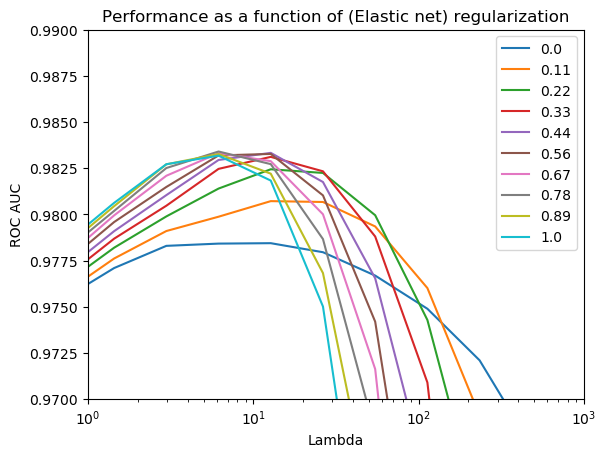

In [76]:
# Plot AUC and n_features for different lambdas
scores = search_enet.cv_results_["mean_test_score"].reshape(len(Cs),len(l1l2))
lines = plt.plot(1/Cs, scores)
plt.legend(lines, np.round(l1l2,2))
plt.xscale('log')
plt.xlim(1e0, 1e3)
plt.ylim([0.97, .99])
plt.xlabel('Lambda')
plt.ylabel('ROC AUC')
plt.title('Performance as a function of (Elastic net) regularization')

Here 0 = Ridge; 1 = LASSO. Max performance is very similar to pure LASSO, but with stronger regularization the hybrid models start to do a little better than pure Ridge or LASSO (but this is a small difference; note the scaling!)

In [77]:
np.sum(np.abs(coefs_enet[Cs == search_enet.best_params_["clf__C"], l1l2 == search_enet.best_params_["clf__l1_ratio"],:]) > 0)

29

The best model retains 29 features

#### Huber

In [78]:
clf_huber = SGDClassifier(loss = 'modified_huber', penalty='elasticnet', max_iter = 10000)
alpha = np.logspace(-3,3,20) # regularization strength
l1l2 = np.linspace(0,1,10) # 0 = l2 only; 1 = l1 only
pipe = Pipeline([
        ('trf', trf),
        ('clf', clf_huber)
])
params = [{
    "clf__alpha": alpha,
    "clf__l1_ratio": l1l2
}]

search_huber = GridSearchCV(pipe, params, cv = cv, scoring = 'roc_auc')

In [79]:
%%time
search_huber.fit(Xp1, y)

CPU times: user 17min 55s, sys: 35min 56s, total: 53min 52s
Wall time: 10min 27s


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=40),
             estimator=Pipeline(steps=[('trf',
                                        PowerTransformer(method='box-cox')),
                                       ('clf',
                                        SGDClassifier(loss='modified_huber',
                                                      max_iter=10000,
                                                      penalty='elasticnet'))]),
             param_grid=[{'clf__alpha': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019....84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03]),
                          'clf__l1_ratio': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.5555555

In [80]:
search_huber.best_score_

0.9833815845219601

This is very comparable to LASSO / elastic net

#### Random Forest

In [81]:
clf_rf = RandomForestClassifier(random_state=40)
np.mean(cross_val_score(clf_rf, X, y, cv=cv, scoring = 'roc_auc'))

0.9912558838826646

Completely untuned random forest with no feature preprocessing does even better still, but the increase in AUC is not worth the decrease in interpretability... Note though that this performs even a bit better than the (extensively tuned) XGBoost!